## Importing libraries

In [1]:
import scanpy as sc
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import seaborn as sns
from time import sleep
import pickle
import matplotlib.pyplot as plt
from IPython import display
import anndata 

In [9]:
#reading the adata file
adata = sc.read_h5ad('velocity_anndata_mouse_embryonic_stem_cells_DeepCycle_ISMARA.h5ad')

#creating a df for the cell cycle theta values
dd = adata.obs['cell_cycle_theta']
dr = pd.DataFrame(dd)

#creating a df for the gene expression values
df = adata.to_df(layer="matrix")

#loading the list of cycling genes
data = open("osc_genes_scrna.txt", "r")
cyc_genes= data.read() 
cyc_genes = cyc_genes.split("\n") 
data.close()

#removing nin cycling genes from the gene expression df
df= df[df.columns.intersection(cyc_genes)]

#merging the dfs
df['cell_cycle_theta'] = dr['cell_cycle_theta'].values

(5637, 12238)


In [3]:
df['cell_cycle_theta'] = df['cell_cycle_theta']. round(2)

In [40]:
df.to_csv('mESCs_data_rounded_new.csv', index=False)

## Preparing the Data

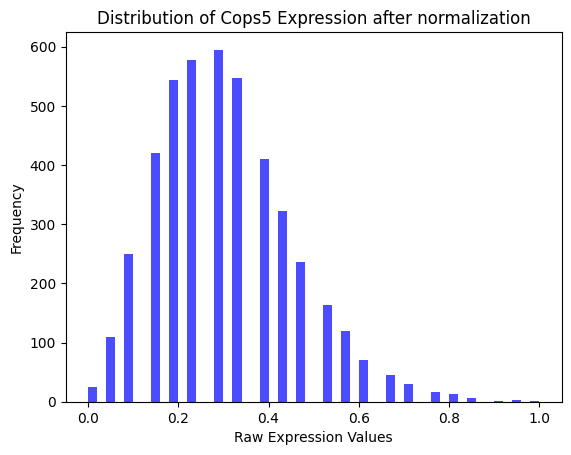

In [26]:
#Data split
X= df.iloc[:, :-1]
y=df.iloc[: , -1]

##Convert to numpy arrays
#X =X.values
#y= y.values

#Train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

#Normalize Input
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


#Convert X features to float tensors
X_train=torch.tensor(X_train, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32)

#Convert y labels to float tensors
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#round up to 2 decimals only 
X_train=torch.round(X_train, decimals=2)
X_test=torch.round(X_test, decimals=2)
y_train=torch.round(y_train, decimals=2)
y_test=torch.round(y_test, decimals=2)

#sin and cos for the labels
y_train_cos  =  torch.cos(y_train)
y_train_sin  =  torch.sin(y_train)
y_test_cos   =  torch.cos(y_test)
y_test_sin   =  torch.sin(y_test)

In [26]:
#number of samples that will be propagated through the network
batch_size = 100
#DataLoader for training data
train_data = torch.utils.data.TensorDataset(X_train, y_train_sin, y_train_cos)
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

## Model Architecture



In [27]:
class MultipleCircularRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultipleCircularRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 100)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(100, 10)
        self.dropout3 = nn.Dropout(0.5)
        self.sin_out= nn.Linear(10,1)
        self.cos_out= nn.Linear(10,1)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc3(out))
        out = self.dropout3(out)
        sin_out = torch.sin(2 * torch.pi * self.sin_out(out))
        cos_out = torch.cos(2 * torch.pi * self.cos_out(out))
        return sin_out, cos_out

In [28]:
# Pick a manual seed for randomization
torch.manual_seed(42)
# Create an instance of model
input_dim=X_train.shape[1]
MCR_model = MultipleCircularRegression(input_dim,2)

In [29]:
# Define a custom loss function
class CyclicLoss(nn.Module):
    def __init__(self):
        super(CyclicLoss, self).__init__()
        
    def forward(self,pred_cos, pred_sin,target_cos, target_sin):
        loss= 1- torch.cos(torch.atan2(pred_cos,pred_sin) - torch.atan2(target_cos,target_sin))
        return torch.mean(loss)

criterion=CyclicLoss()
optimizer = torch.optim.Adam(MCR_model.parameters(), lr=0.001)

## Training Process

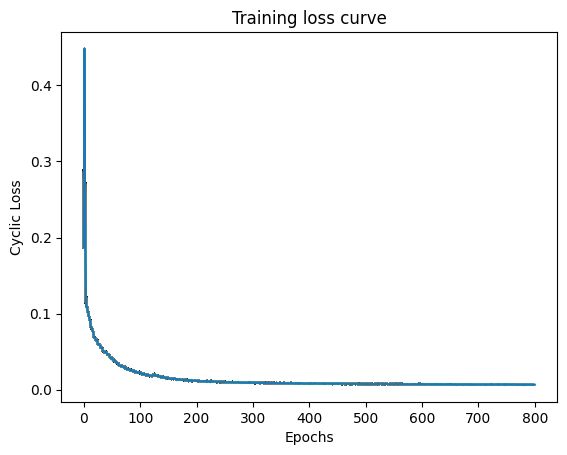

100%|████████████████████████████████████████████████████████████████████████████████| 801/801 [05:43<00:00,  2.33it/s]


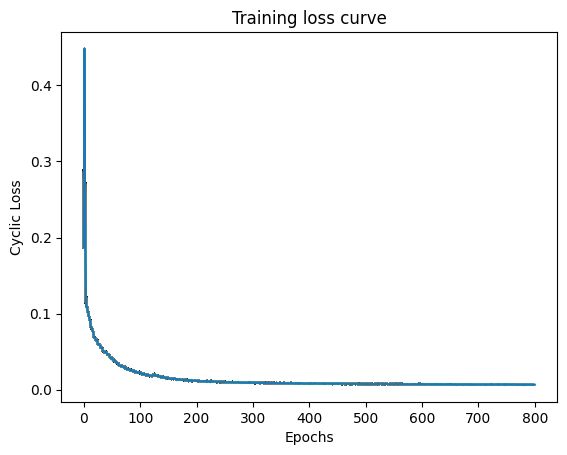

In [30]:
# Train our model
epochs=800 
Loss = [] #empty list to plot losses later

for i in tqdm(range(epochs+1)):
    #input data & model initializing
    y_pred_sin, y_pred_cos=MCR_model(X_train)
    #Measure the loss/error, gonna be high at first
    loss = criterion(y_pred_cos.squeeze(), y_pred_sin.squeeze(),y_train_cos,y_train_sin)
    
    #keep track on loss 
    Loss.append(loss.item())
    
    #Back propagation
    optimizer.zero_grad()#zero out the gradients from the previous minibatch
    loss.backward()# back propagation
    optimizer.step()# update weights in NN
    
    #plot loss curve live
    plt.plot(Loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cyclic Loss')
    plt.title('Training loss curve')
    display.clear_output(wait=True)
    display.display(plt.gcf())

plt.show()

In [31]:
print(Loss[-1])

0.006390080321580172


## Evaluation and Performance:

In [32]:
with torch.no_grad():#turn off back propagation
    MCR_model.eval() #model in evaluation stage
    y_pred_sin, y_pred_cos=MCR_model(X_test)
    test_loss=criterion(y_pred_cos.squeeze(), y_pred_sin.squeeze(),y_test_cos,y_test_sin)#find loss or error
    print(f'Test loss value : {test_loss.item():.4f}')

Test loss value : 0.0088


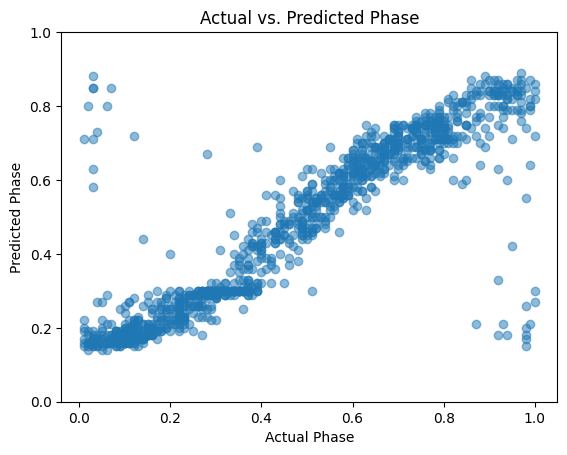

In [33]:
# Predict on the test set
phase_predic=[]
phase_actual=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
            y_pred_sin, y_pred_cos= MCR_model.forward(data)
            pred_phase = torch.atan2(y_pred_sin.squeeze(), y_pred_cos.squeeze()) 
            actual_phase=torch.atan2(y_test_sin, y_test_cos) 
            actual_phase=round(actual_phase[i].item(), 2)
            pred_phase=round(pred_phase.item(), 2)
            #print(f'{i+1}.) {str(pred_phase)} \t {actual_phase} \t {pred_phase}')
            phase_actual.append(actual_phase)
            phase_predic.append(pred_phase)

# Scatter plot
plt.scatter(phase_actual, phase_predic, alpha=0.5)
plt.xlabel("Actual Phase")
plt.ylabel("Predicted Phase")
plt.ylim(0,1)
plt.title("Actual vs. Predicted Phase")
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error        
r2_score2 = r2_score(phase_actual,phase_predic)
MAE = mean_absolute_error(phase_actual,phase_predic)
RMSE = np.sqrt(mean_squared_error(phase_actual,phase_predic))
print(f"MAE={MAE}")
print(f"RMSE={RMSE}")
print(f"r2_score={r2_score2}")

MAE=0.07359042553191489
RMSE=0.13468146028567127
r2_score=0.7690210024121492


## Feature importance

In [36]:
pip install captum

     ---------------------------------------- 1.3/1.3 MB 8.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
from captum.attr import FeaturePermutation

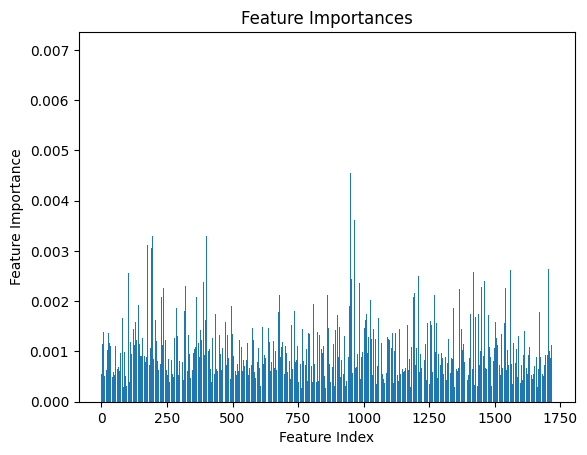

In [38]:
#Forward function for Captum
def forward_func(input_data):
    MCR_model.eval()
    with torch.no_grad():
        pred_sin, pred_cos = MCR_model(input_data)
        pred_phase = torch.atan2(pred_sin.squeeze(), pred_cos.squeeze())
    return pred_phase.unsqueeze(0)

#creating a FeaturePermutation object
feature_permutation = FeaturePermutation(forward_func)

# Compute feature importances
attributions = feature_permutation.attribute(X_test)

# Plot feature importances for all genes
feature_importances = attributions.abs().mean(dim=0).numpy()
plt.bar(range(len(feature_importances)),feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Feature Importances")
plt.show()

#Get the column names as a list
liste =list(df.columns) #genes
labels= liste[:-1]

#creating a df for the features and their importance
df_features = pd.DataFrame(feature_importances).T
df_features.columns=labels

#getting the top 100 features 
row = df_features.iloc[0]
top_features = row.nlargest(100)
df_top_features = pd.DataFrame({'Index': top_features.index, 'Max_Values': top_features.values})

In [41]:
#getting the top 20 features 
row = df_features.iloc[0]
top_features = row.nlargest(20)
df_top_20_features = pd.DataFrame({'Index': top_features.index})
df_top_20_features.to_csv('top_20_genes.txt', sep='\t', index=False)

## Data Visualization

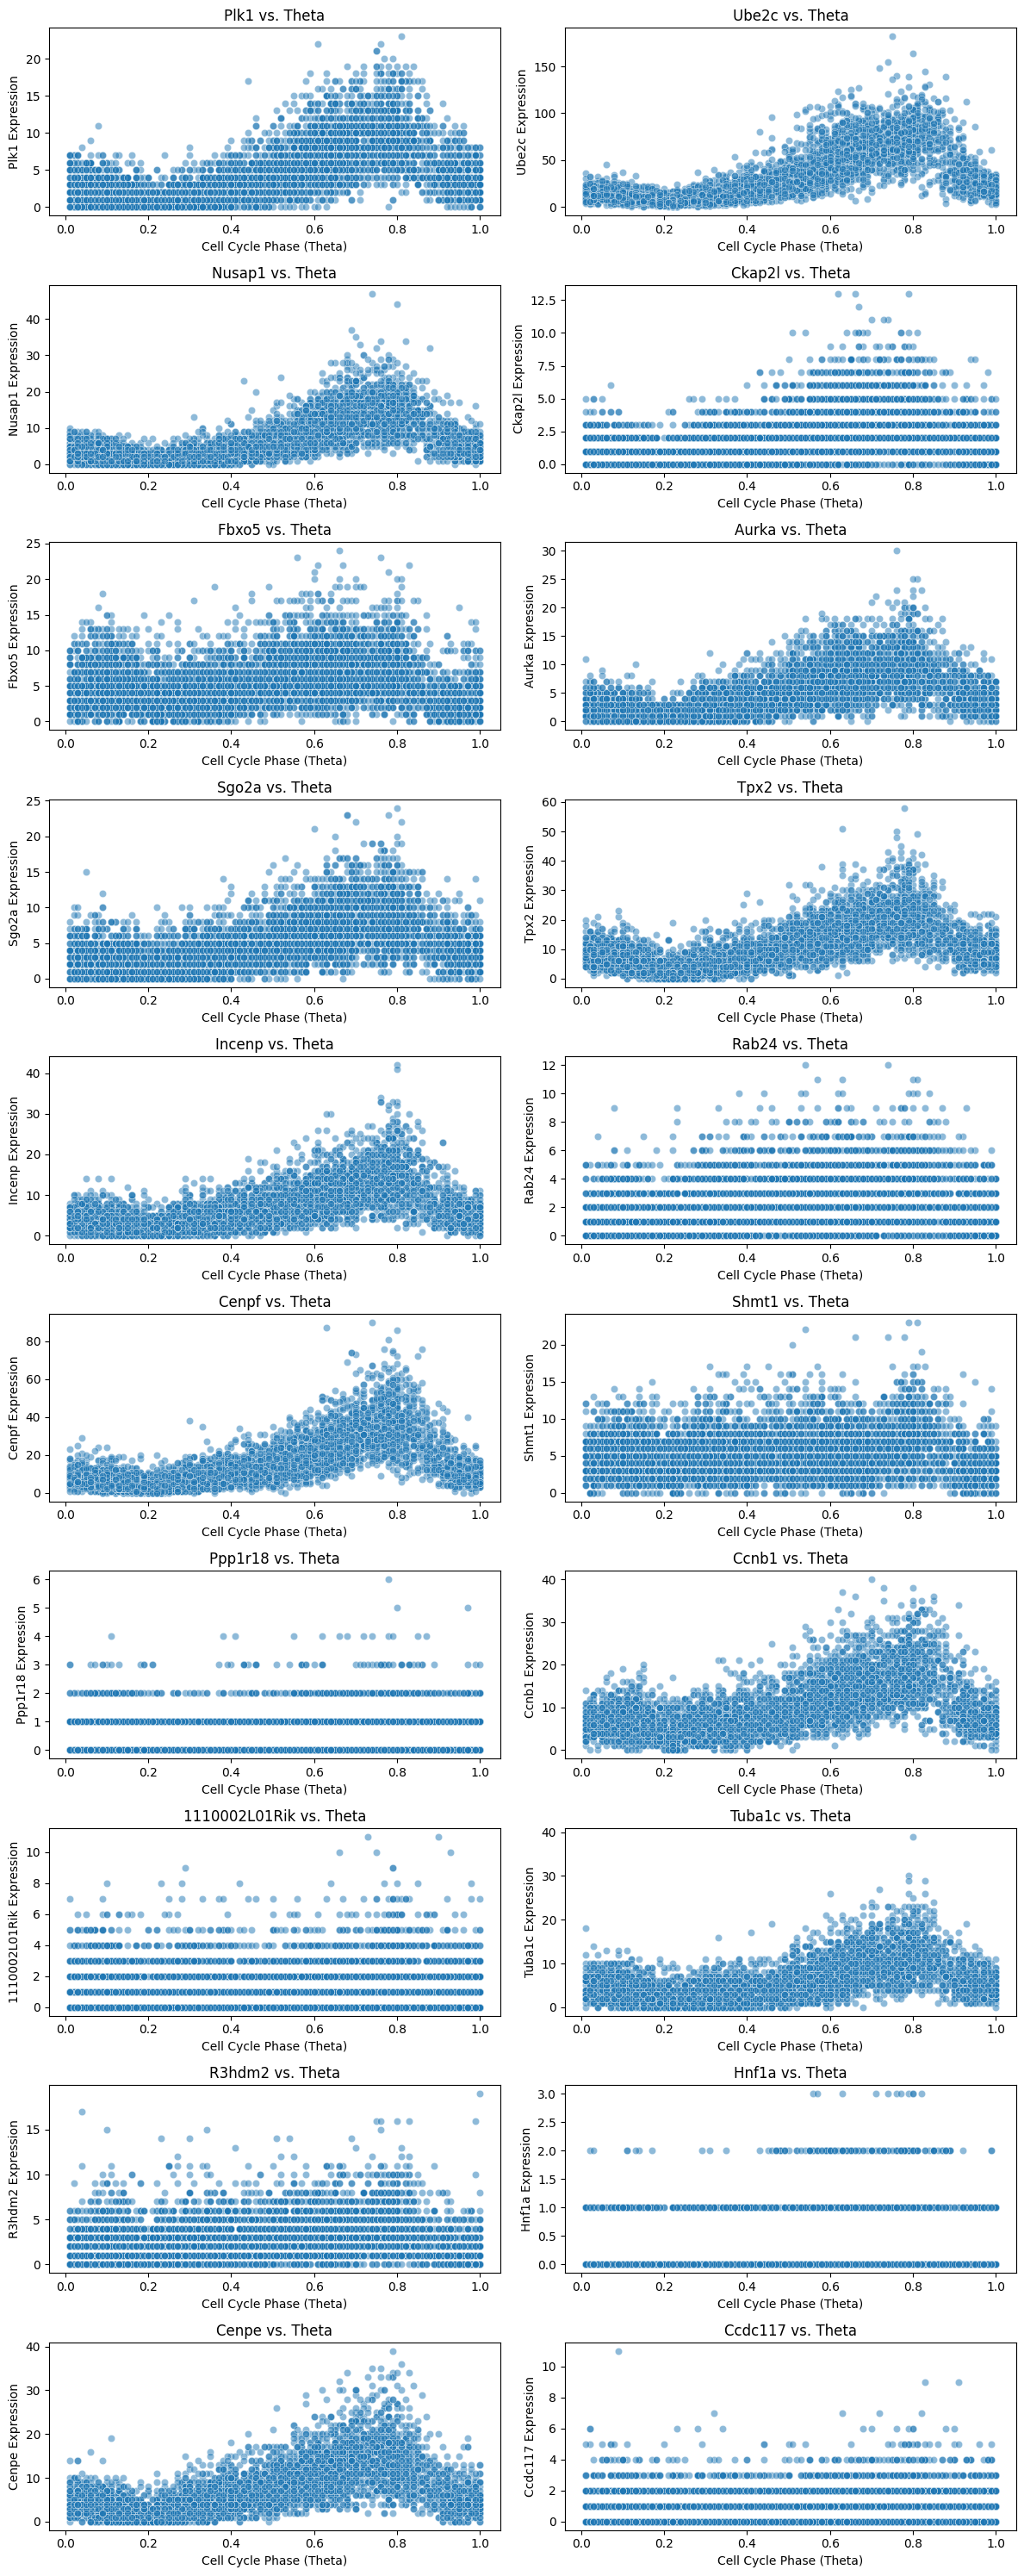

In [49]:
#loading the list of top 20 genes
data = open("top_20_genes.txt", "r")
top_20_genes= data.read() 
top_20_genes = top_20_genes.split("\n") 
data.close()

#removing non cycling genes from the gene expression df
df= df[df.columns.intersection(top_20_genes)]

#merging the dfs
df['cell_cycle_theta'] = dr['cell_cycle_theta'].values

#Subplots
num_genes = len(top_20_genes)
num_rows = (num_genes // 2) + (num_genes % 2)  # Calculates the number of rows for subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 3 * num_rows), sharey=False)

#for easy iteration
axes = axes.flatten()

#scatter plots for each gene against the cell cycle phase
for i, gene in enumerate(top_20_genes):
    ax = axes[i]
    sns.scatterplot(data=df, y=gene, x='cell_cycle_theta', ax=ax, alpha=0.5)
    ax.set_ylabel(f'{gene} Expression')
    ax.set_xlabel('Cell Cycle Phase (Theta)')
    ax.set_title(f'{gene} vs. Theta')

plt.tight_layout()
plt.savefig('Genes_VS_Theta.png')
plt.show()